In [1]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import time

if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [2]:
g = 9.82 #重力加速度
m = 0.135 #振子の質量
l = 0.26 #振子の長さ
I = m*((l*l) + (0.6*0.6+0.08*0.08)/12.)
print("I:",I)
c = 0.001
k = 0.001*1.97 # トルク定数：モータ個体のデータをとってフィッティングして取得した

nu = 1 # 制御変数の次元
nx = 2 # 状態変数の次元

# 予測ホライズン等
T = 2.5 # ここを変更！
N = 50 # 100 #50  # ここを変更！
dt = T/N

# 制約条件
x_lb = [-np.inf,-np.inf]
x_ub = [np.inf,np.inf]
u_lb = [-125]
u_ub = [125]

total = nx*(N+1) + nu*N

I: 0.013248000000000001


In [3]:
def make_f():
    vars = casadi.SX.sym("vars",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    theta = vars[0]
    theta_dot = vars[1]

    theta_ddot = ( -c*theta_dot +m*g*l*casadi.sin(theta) + k*ctrls ) / I

    vars_dot = casadi.vertcat(theta_dot,theta_ddot)

    f = casadi.Function("f",[vars,ctrls],[vars_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    vars = casadi.SX.sym("vars",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    k1 = f(x=vars,u=ctrls)["x_dot"]
    k2 = f(x=vars+dt*k1/2,u=ctrls)["x_dot"]
    k3 = f(x=vars+dt*k2/2,u=ctrls)["x_dot"]
    k4 = f(x=vars+dt*k3,u=ctrls)["x_dot"]

    vars_next = vars + dt*(k1+2*k2+2*k3+k4)/6

    
    RK4 = casadi.Function("RK4",[vars,ctrls],[vars_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    vars = casadi.SX.sym("vars",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=vars, u=ctrls)["x_dot"]

    dae = {"x":vars,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    return 1-casadi.cos(x[0]) + 0.05*x[1]*x[1] # ここを変更！

def compute_final_cost(x):
    return 1-casadi.cos(x[0]) + 0.05*x[1]*x[1] # ここを変更！


In [4]:
def make_nlp(online_flag=False):
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(N)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(N+1)]
    G = []

    J = 0

    for k in range(N):
        J += compute_stage_cost(X[k],U[k])
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_final_cost(X[-1])

    if online_flag:
        option = {'print_time':False,
                  'ipopt':{
                        'print_level':0,
                        'max_iter':3, # ここを変更！
                    }}
    else:
        option = {'print_time':False,'ipopt':{'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [5]:
def compute_optimal_control(S,x_s,x0,lam_x0=None,lam_g0=None):
    x_s = x_s.full().ravel().tolist()
    
    lbx = x_s + x_lb*N + u_lb*N
    ubx = x_s + x_ub*N + u_ub*N
    lbg = [0]*nx*N
    ubg = [0]*nx*N

    if (lam_x0 is not None) and (lam_g0 is not None):
        res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0,lam_x0=lam_x0,lam_g0=lam_g0)
    else:
        res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(N+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    
    return u_opt, x0, res["lam_x"], res["lam_g"]

In [6]:
S_warmup = make_nlp()
S_online = make_nlp(online_flag=True)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



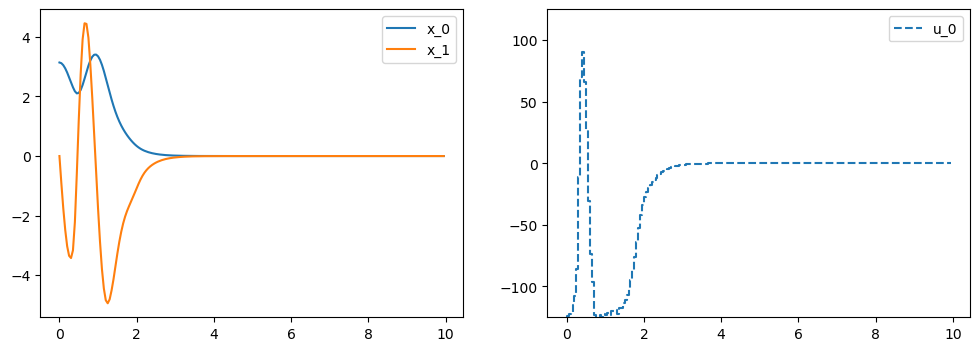

In [7]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)

x_init = casadi.DM([1.0*np.pi,0.0]) # 初期値
x0 = casadi.DM.zeros(total) # 最適化問題の解の初期推定
lam_x0 = None # 双対変数の初期推定
lam_g0 = None # 双対変数の初期推定

I = make_integrator()

X = [x_init]
U = []
x_current = x_init
compute_time=[]
for t in t_eval:
    start_time =time.time()
    if lam_x0 is None:
        u_opt,x0,lam_x0,lam_g0 = compute_optimal_control(S_warmup,x_current,x0,None,None)
    else:
        u_opt,x0,lam_x0,lam_g0 = compute_optimal_control(S_online,x_current,x0,lam_x0,lam_g0) # 双対変数の初期推定を与える場合
        # u_opt,x0,lam_x0,lam_g0 = compute_optimal_control(S_online,x_current,x0,None,None) # 双対変数の初期推定を与えない場合
    x_current = I(x0=x_current,p=u_opt)["xf"]
    compute_time.append(time.time()-start_time)
    X.append(x_current)
    U.append(u_opt)
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
    plt.ylim([u_lb[0],u_ub[0]])
plt.legend()

plt.show()

In [8]:
S_online.generate_dependencies("nlpsol_swingup.c")

'nlpsol_swingup.c'

init_compute_time: 0.1024482250213623
runtime_compute_time_max: 0.00314753379055004
runtime_compute_time_mean: 0.004670858383178711


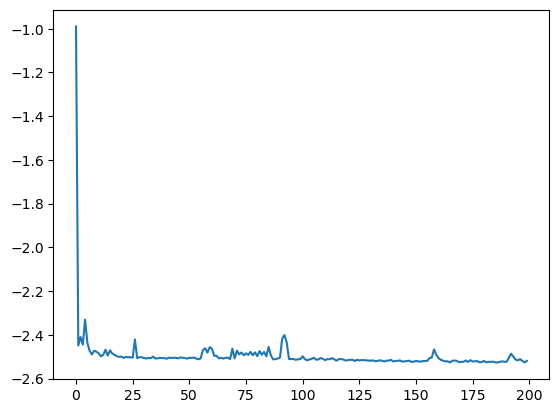

In [9]:
compute_time=np.array(compute_time)
print("init_compute_time:",compute_time[0])
print("runtime_compute_time_max:",compute_time[1:].mean())
print("runtime_compute_time_mean:",compute_time[1:].max())

plt.plot(np.log10(compute_time))
plt.show()


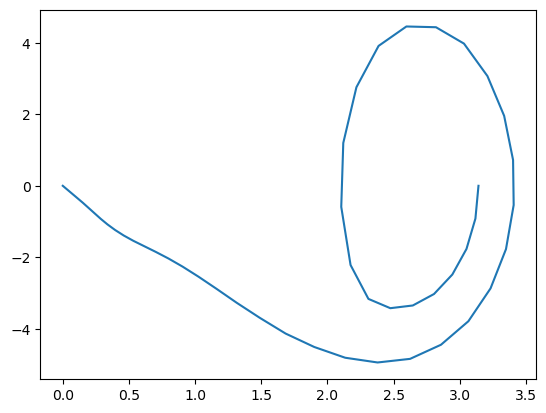

In [10]:
plt.plot(X[:,0],X[:,1])